# [DRAFT] Body forces

## TODO:

* The remaining fundamental issue is the singularity in the volume integral. Set up a way of testing the accuracy of this integral.
* There's something preventing convergence in the L2 and Linf norms that isn't preventing convergence in the L1 norm. That suggests that the problem is some kind of outlier. The problem might be the scalloping in the QBX zone!!!
* Fix the scalloping issue!
* Measure the error just inside r < 0.99.
* Getting an exterior solution would be nice!

For the Poisson equation with Dirichlet boundary conditions:
\begin{split}
\nabla u &= f  ~~ \textrm{in} ~~ \Omega\\
u &= g ~~ \textrm{on} ~~ \partial \Omega
\end{split}
`u_particular` is the integral:

\begin{equation}
v(x) = \int_{\Omega} G(x,y) f(y) dy
\end{equation}

which satisfies equation 1 but not 2.

Then, compute homogeneous solution, `u_homog` with appropriate boundary conditions:

\begin{split}
\nabla u^H &= 0 ~~ \textrm{in} ~~ \Omega \\
u^H &= g - v|_{\partial \Omega}  ~~ \textrm{on} ~~ \partial \Omega
\end{split}

So, first, I need to compute $g - v|_{\partial \Omega}$

## Setup

In [1]:
from tectosaur2.nb_config import setup

setup()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

from tectosaur2 import integrate_term, refine_surfaces, gauss_rule, trapezoidal_rule
from tectosaur2.laplace2d import single_layer, double_layer

In [3]:
nq = 10
qx, qw = gauss_rule(nq)

t = sp.symbols("t")
theta = sp.pi * (t + 1)
circle = refine_surfaces([(t, sp.cos(theta), sp.sin(theta))], (qx,qw))
circle.n_pts, circle.n_panels

(320, 32)

In [4]:
x, y = sp.symbols('x, y')
sym_soln = 2 + x + y + x**2 + y*sp.cos(6*x) + x*sp.sin(6*y)

sym_laplacian = (
    sp.diff(sp.diff(sym_soln, x), x) +
    sp.diff(sp.diff(sym_soln, y), y)
)
soln_fnc = sp.lambdify((x, y), sym_soln, "numpy")
laplacian_fnc = sp.lambdify((x, y), sym_laplacian, "numpy")

sym_soln

x**2 + x*sin(6*y) + x + y*cos(6*x) + y + 2

In [5]:
sym_laplacian

-36*x*sin(6*y) - 36*y*cos(6*x) + 2

## Body force quadrature

In [6]:
nq_r = 40
nq_theta = 80
qgauss, qgauss_w = gauss_rule(nq_r)
qtrap, qtrap_w = trapezoidal_rule(nq_theta)
r = 0.5 * (qgauss + 1)
r_w = qgauss_w * 0.5
theta = (qtrap + 1) * np.pi
theta_w = qtrap_w * np.pi

r_vol, theta_vol = [x.flatten() for x in np.meshgrid(r, theta)]
qx_vol = np.cos(theta_vol) * r_vol
qy_vol = np.sin(theta_vol) * r_vol

q2d_vol = np.array([qx_vol, qy_vol]).T.copy()
q2d_vol_wts = (r_w[None, :] * theta_w[:, None] * r[None, :]).flatten()

In [7]:
np.sum(q2d_vol_wts) - np.pi, np.sum(np.cos(theta_vol) * q2d_vol_wts), np.sum(r_vol * q2d_vol_wts) - 2.0943951023931954

(0.0, 1.1102230246251565e-16, 4.440892098500626e-16)

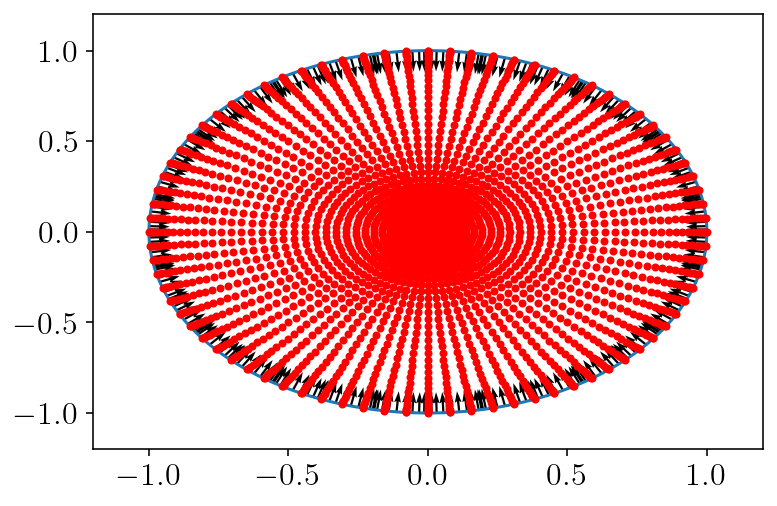

In [8]:
plt.plot(circle.pts[:, 0], circle.pts[:, 1])
plt.quiver(circle.pts[:, 0], circle.pts[:, 1], circle.normals[:, 0], circle.normals[:, 1])
plt.plot(q2d_vol[:, 0], q2d_vol[:, 1], "r.")
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.show()

In [9]:
nobs = 200
offset = -0.1
zoomx = [-1.0 + offset, 1.0 - offset]
zoomy = [-1.0 + offset, 1.0 - offset]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
obs2d = np.array([obsx.flatten(), obsy.flatten()]).T.copy()
obs2d_mask = np.sqrt(obs2d[:,0] ** 2 + obs2d[:,1] ** 2) <= 1
obs2d_mask_sq = obs2d_mask.reshape(obsx.shape)

In [37]:
fxy = -laplacian_fnc(q2d_vol[:,0], q2d_vol[:,1])

correct = soln_fnc(obsx, obsy)
fxy_obs = -laplacian_fnc(obsx, obsy)

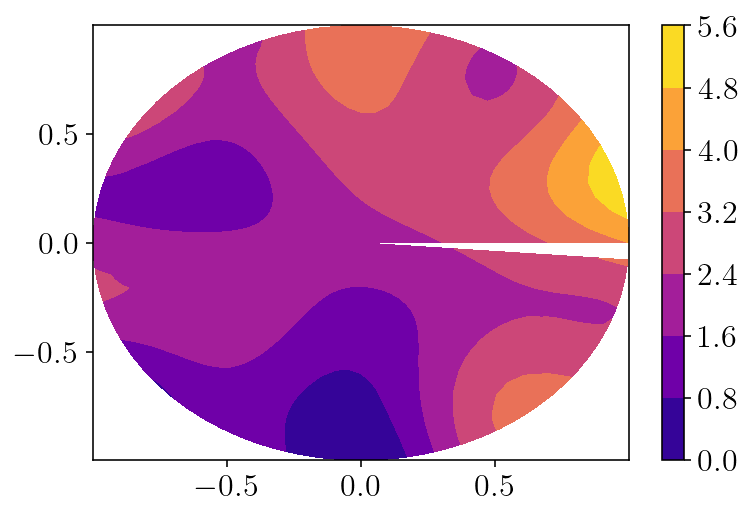

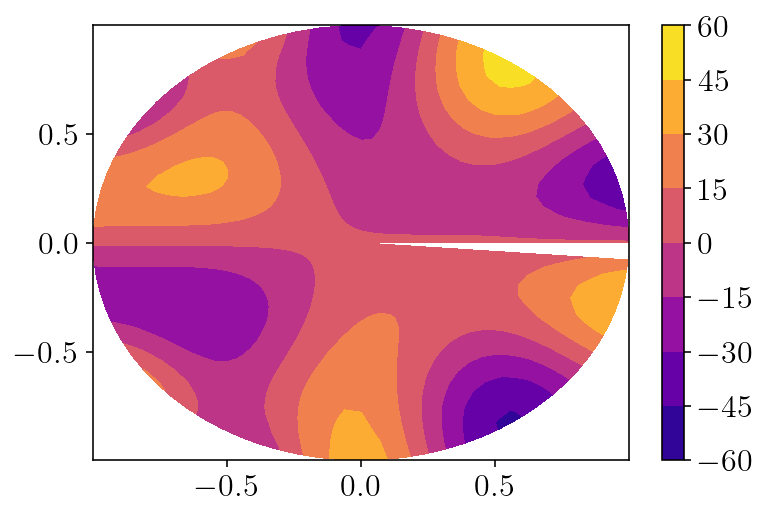

In [38]:
plotx = q2d_vol[:,0].reshape((nq_theta, nq_r))
plt.contourf(plotx, q2d_vol[:,1].reshape(plotx.shape), soln_fnc(q2d_vol[:,0], q2d_vol[:,1]).reshape(plotx.shape))
plt.colorbar()
plt.show()
plotx = q2d_vol[:,0].reshape((nq_theta, nq_r))
plt.contourf(plotx, q2d_vol[:,1].reshape(plotx.shape), laplacian_fnc(q2d_vol[:,0], q2d_vol[:,1]).reshape(plotx.shape))
plt.colorbar()
plt.show()

In [39]:
u_particular = (
    (single_layer.kernel(obs2d, q2d_vol, 0*q2d_vol)[:,0,:,0] * q2d_vol_wts[None,:])
    .dot(fxy)
    .reshape(obsx.shape)
)

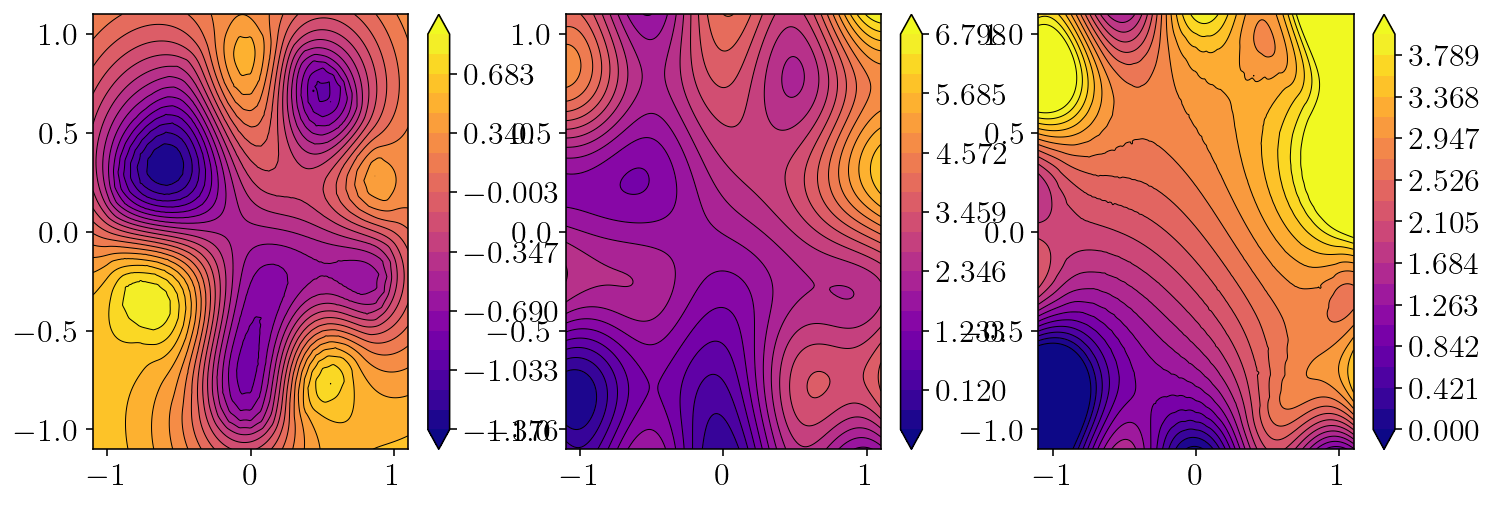

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
levels = np.linspace(np.min(u_particular), np.max(u_particular), 21)
cntf = plt.contourf(obsx, obsy, u_particular, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    u_particular,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.subplot(1,3,2)
levels = np.linspace(np.min(correct), np.max(correct), 21)
cntf = plt.contourf(obsx, obsy, correct, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    correct,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.subplot(1,3,3)
err = correct - u_particular
levels = np.linspace(0, 4, 20)
cntf = plt.contourf(obsx, obsy, err, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    err,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.show()

## Direct to surface eval

In [41]:
## This is g
bcs = soln_fnc(circle.pts[:, 0], circle.pts[:, 1])
## This is v|_{\partial \Omega}
surf_vals = (single_layer.kernel(circle.pts, q2d_vol)[:,0,:,0] * q2d_vol_wts[None,:]).dot(fxy)
A,report = integrate_term(double_layer, circle.pts, circle, return_report=True)
surf_density = np.linalg.solve(-A[:,0,:,0], bcs-surf_vals)

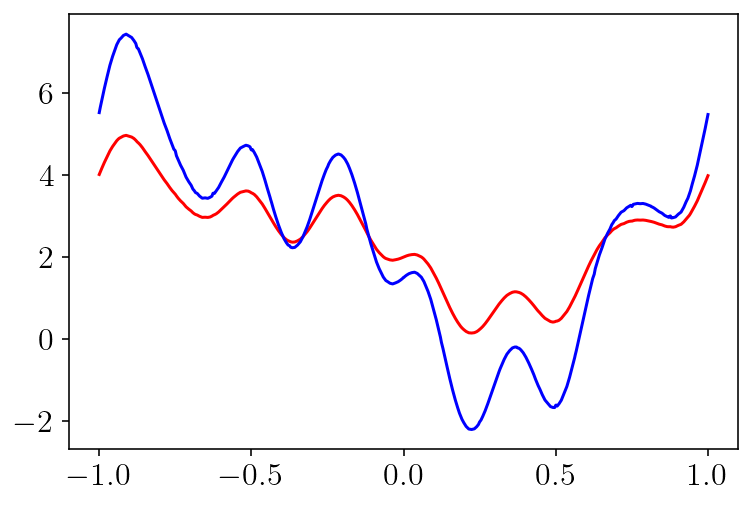

In [42]:
plt.plot(circle.quad_pts, bcs-surf_vals, 'r-')
plt.plot(circle.quad_pts, surf_density, 'b-')
plt.show()

In [43]:
%%time
interior_disp_mat = integrate_term(double_layer, obs2d, circle, tol=1e-13)
u_homog = -interior_disp_mat[:, 0, :, 0].dot(surf_density).reshape(obsx.shape)

CPU times: user 1.03 s, sys: 248 ms, total: 1.28 s
Wall time: 418 ms


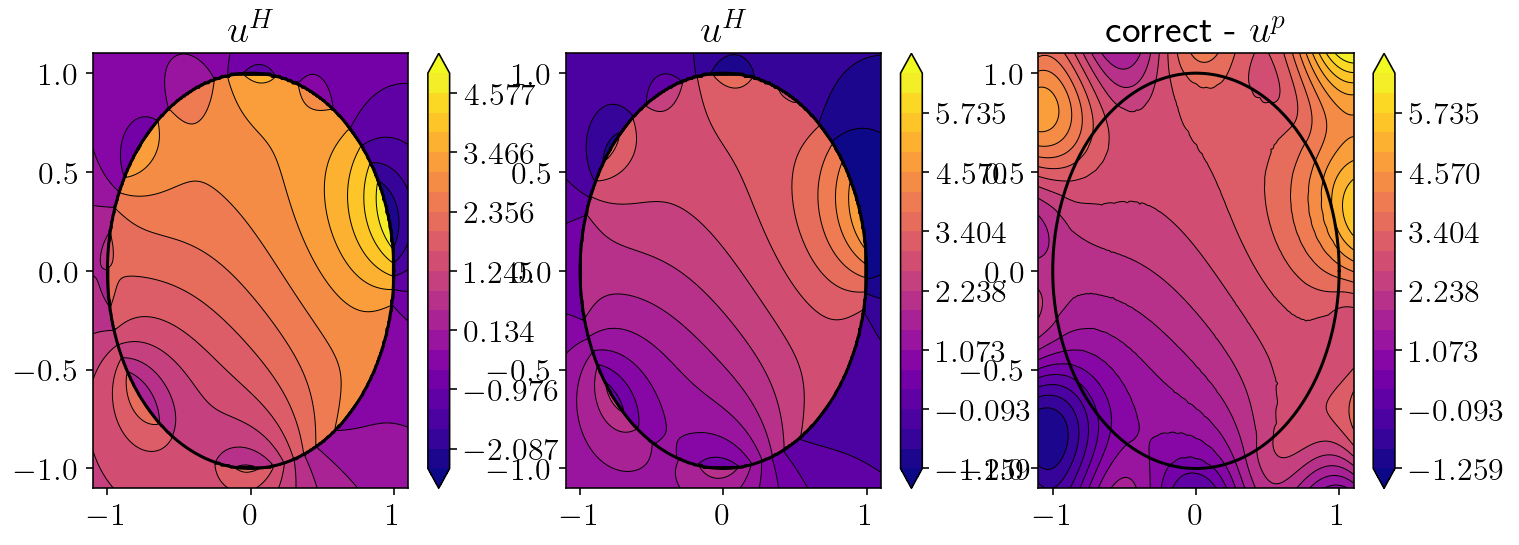

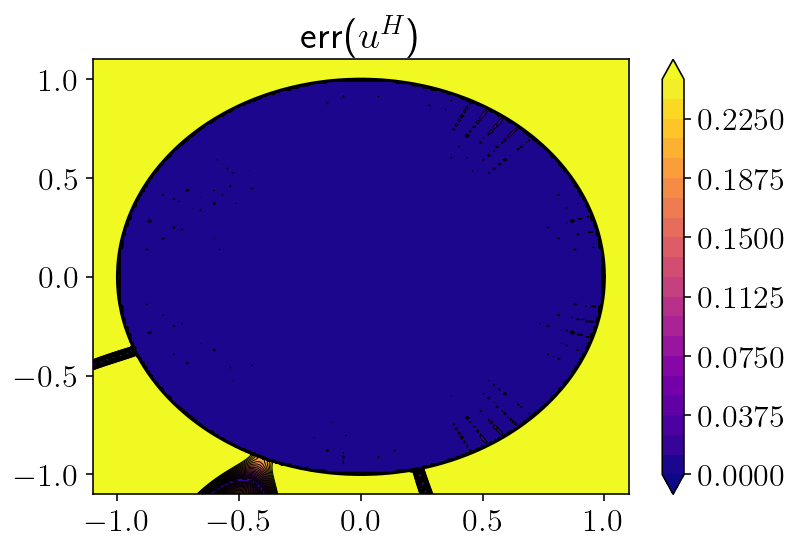

In [44]:
plt.figure(figsize=(12,4))
for i, to_plot in enumerate([u_homog, u_homog, correct - u_particular]):
    plt.subplot(1,3,1+i)
    if i == 0:
        levels = np.linspace(np.min(to_plot), np.max(to_plot), 21)
    else:
        levels = np.linspace(np.min(correct - u_particular), np.max(correct - u_particular), 21)

    cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        to_plot,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(circle.pts[:, 0], circle.pts[:, 1], "k-", linewidth=1.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(['$u^H$', '$u^H$', 'correct - $u^p$'][i])
plt.figure()
to_plot = np.abs(correct - u_particular - u_homog)
levels = np.linspace(0, 0.25, 21)
cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    to_plot,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(circle.pts[:, 0], circle.pts[:, 1], "k-", linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.title('err($u^H$)')
plt.show()

## Full solution!

In [45]:
#u_full = u_box + u_particular
u_full = u_homog + u_particular

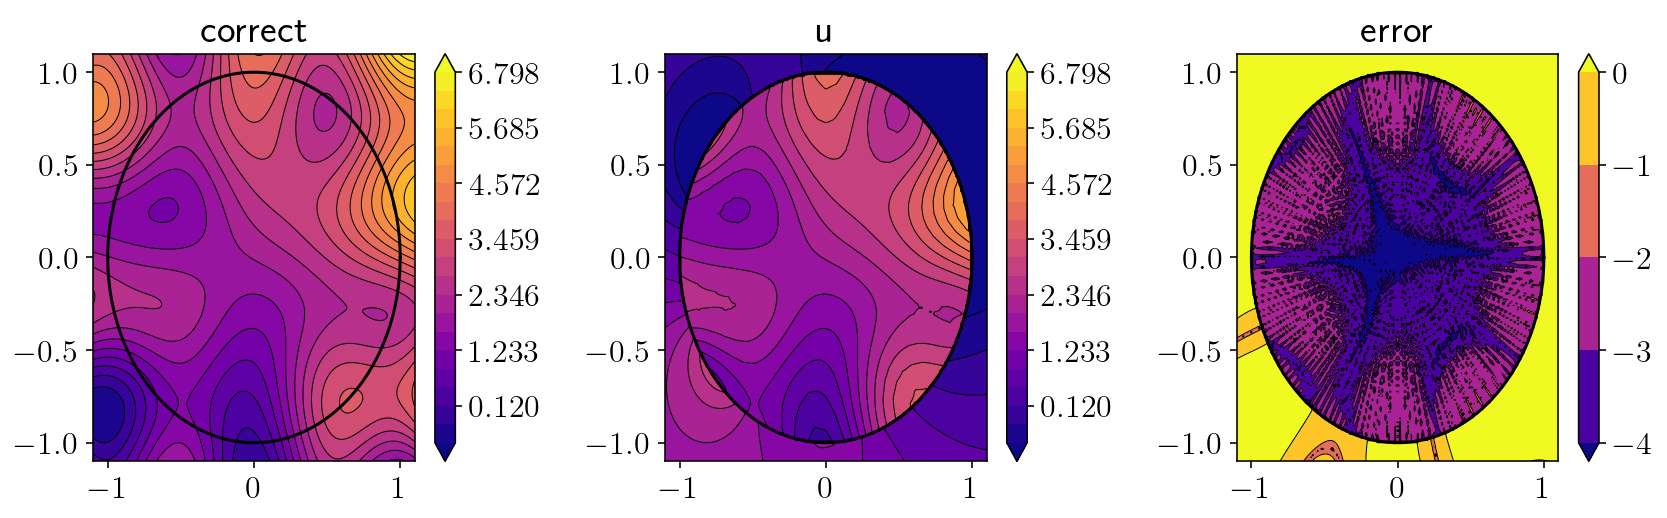

In [46]:
plt.figure(figsize=(12,4))
for i, to_plot in enumerate([correct, u_full]):
    plt.subplot(1,3,1+i)
    levels = np.linspace(np.min(correct), np.max(correct), 21)
    cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        to_plot,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(circle.pts[:, 0], circle.pts[:, 1], "k-", linewidth=1.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(['correct', 'u'][i])

plt.subplot(1,3,3)
to_plot = np.log10(np.abs(correct - u_full))
levels = np.linspace(-4, 0, 5)
cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    to_plot,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(circle.pts[:, 0], circle.pts[:, 1], "k-", linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.title('error')
plt.tight_layout()
plt.show()

In [47]:
for norm in [np.linalg.norm, lambda x: np.linalg.norm(x, ord=1), lambda x: np.linalg.norm(x, ord=np.inf)]:
    A = norm(correct[obs2d_mask_sq] - u_full[obs2d_mask_sq])
    B = norm(correct[obs2d_mask_sq])
    print(A, B, A/B)

0.48690183858286906 387.36567421386707 0.0012569565942336116
44.90276575487436 57753.86762570072 0.0007774849997213422
0.04552160744059597 5.342989553063169 0.00851987580894635


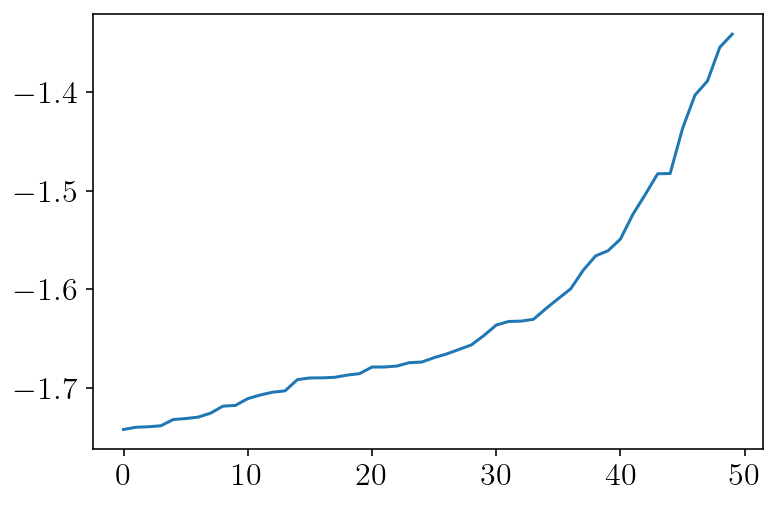

In [48]:
E = correct[obs2d_mask_sq] - u_full[obs2d_mask_sq]
plt.plot(np.log10(sorted(np.abs(E).tolist()))[-50:])
plt.show()